<div style="text-align: center;">
<h1>Cinematic ROI and Audience Dynamics:<br />
Financial Efficiency, Genre Fatigue, and Global Film Trends</h1>
</div>

<hr />
<h3>Initial Project Overview:</h3>
<p>This project analyzes the <a href="https://www.kaggle.com/datasets/mustafasayed1181/movies-metadata-cleaned-dataset-19002025/" target=_blank>Movies Metadata Cleaned Dataset (1900–2025)</a>, a large scale collection of over 946,000 films sourced from <a href="https://www.themoviedb.org/" target=_blank>The Movie Database (TMDB)</a>. Using variables such as budget, revenue, genres, countries, languages, popularity, and ratings, the study examines three analytical issues:
<ol><li>How production budgets translate into financial efficiency and return on investment (ROI).</li>
<li>How movie attributes relate to audience reception and popularity.</li>
<li>How inflation adjusted financial performance and genre level fatigue have evolved across decades and regions.</li></ol></p> 
<p>The goal is to identify budget sweet spots, quantify potential diminishing returns and genre saturation, and map long term shifts in global film success.</p>

<p><span style="font-weight: bold;">Research Questions</span>
    <ul>
        <li>Once we adjust for inflation, do small indie films, mid-sized movies, or massive blockbusters make the most profit relative to their cost?</li>
        <li>Is there a limit to how much money a studio should spend?</li>
        <li>How do things like a movie’s genre, length, or language affect how many people watch it and how much they like it? Do big-name studios and high budgets automatically guarantee a movie will be popular?</li>
        <li>How have things like runtime and profits changed across the decades and between different countries?</li>
        <li>Does genre fatigue exist? Does releasing too many movies of the same type cause ratings to crash?</li>
    </ul>
</p>
<hr />

<h4>Data Preprocessing:</h4>

<p>The initial dataset contained 946,460 records of films spanning the years 1900-2025. I began by eliminating shorts from the dataset and focusing only on feature-length films (over 60 mins). From there, I limited the dataset to films from 1930-2025 to focus on releases from the Golden Age of cinema to today.</p>

<p>To adjust for inflation, all budgets and revenues were calculated in today’s money using the CPI from the US Bureau of Labor Statistics (BLS) for 1997-2025 and historical CPI from the Federal Reserve bank of Minneapolis for dates before 1997.</p>

<p>These steps reduced the dataset to 370,118 records.</p>

<p>After running univariate and multivariate analyses, I chose to remove extreme outliers:
    <ul>
        <li>movies with runtimes greater than 250 minutes</li>
        <li>revenues greater than $5 billion (most likely a data entry error)</li>
    </ul>
</p>

<p>For my scenario analyses, I am focusing on 21st century film releases from the United States. Streaming services surged in popularity in the late 2000s and 2010s, quickly transforming the film industry by weakening the old theatrical‑first model. This pushed many studios to adopt hybrid or direct‑to‑streaming releases, and encouraged heavy investment in original movies and series to attract streaming subscribers. While streaming has opened new opportunities for independent and niche filmmakers to reach global audiences, it has also significantly contributed to declines in box‑office revenue and theater attendance as more viewers choose to watch at home.</p>

<p>I am also removing films with a budget less than $10K to filter out extremly low-budget films or data error entries.</p>

<p>This gives me a final working dataset of 88,352 records.</p>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# Reproducibility
SEED = 42
np.random.seed(SEED)

PALETTE = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

In [2]:
# Load dataset
df = pd.read_excel('../dataset/data_movies_clean.xlsx')  
# Reads the dataset from the specified file path into a Pandas DataFrame named `df`.

In [3]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# Filter results to 21st century feature-length films
df = df[(df['release_date'] > '1999-12-31') & (df['runtime'] > 60)]

# Parse origin_country
def first_country(x):
    try:
        lst = ast.literal_eval(x)
        return lst[0] if lst else np.nan
    except Exception:
        s = str(x).strip().strip("[]").replace("'", "").replace('"', "").strip()
        return s if s else np.nan

df["country"] = df["origin_country"].apply(first_country)

# filter dataframe to only USA movies
df = df[
    (df["country"].notna()) &
    (df["country"] == 'US')
].copy()

In [4]:
# Load modern CPI (1997+) from BLS flat file
cpi_raw = pd.read_csv("../dataset/cu.data.0.Current", sep="\t")

# fix column names
cpi_raw.columns = cpi_raw.columns.str.strip()

# strip whitespace from series_id
cpi_raw["series_id"] = cpi_raw["series_id"].str.strip()

# filter and process modern CPI
series_modern = "CUSR0000SA0"
cpi_modern_raw = cpi_raw[cpi_raw["series_id"] == series_modern].copy()
cpi_modern_raw["value"] = pd.to_numeric(cpi_modern_raw["value"], errors="coerce")

cpi_modern = (
    cpi_modern_raw[cpi_modern_raw["period"].str.startswith("M")]
    .groupby("year", as_index=False)["value"]
    .mean()
    .rename(columns={"value": "cpi"})
    .round(3)
)

# Load historical CPI (1913–1996)
cpi_historical = pd.read_csv("../dataset/cpi_1913.csv")

# Rename columns to match (drop Annual Percent Change column)
if "Annual Percent Change" in cpi_historical.columns:
    cpi_historical = cpi_historical[["Year", "CPI"]].rename(columns={"Year": "year", "CPI": "cpi"})
else:
    cpi_historical = cpi_historical.rename(columns={"Year": "year", "CPI": "cpi"})

cpi_historical["cpi"] = cpi_historical["cpi"].round(3)

# Combine both CPI datasets
cpi_full = pd.concat([cpi_historical, cpi_modern], ignore_index=True)
cpi_full = cpi_full.sort_values("year").drop_duplicates("year").reset_index(drop=True)


# Merge with movies dataframe and create inflation columns
df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year.astype("Int64")

df_cpi_merged = df.merge(cpi_full, left_on="release_year", right_on="year", how="left")
df_cpi_merged.drop(columns=["year"], inplace=True)

# Create inflation adjustment columns (2025 dollars)
base_year = 2025
base_cpi = cpi_full.loc[cpi_full["year"] == base_year, "cpi"].iloc[0]

df_cpi_merged["inflation_factor"] = base_cpi / df_cpi_merged["cpi"]
df_cpi_merged["budget_adj"] = df_cpi_merged["budget"] * df_cpi_merged["inflation_factor"]
df_cpi_merged["revenue_adj"] = df_cpi_merged["revenue"] * df_cpi_merged["inflation_factor"]
df_cpi_merged["profit_adj"] = df_cpi_merged["revenue_adj"] - df_cpi_merged["budget_adj"]

# Copy all back to original dataframe name
df = df_cpi_merged.copy()

In [5]:
# Remove extreme outliers seen in original univariate analyses from the first part of the project
df_cleaned = df[
    (df['runtime'] <= 250) & # notably a 2012 experimental Swedish film with a runtime of 857 hours
    (df['revenue_adj'] < 5000000000) & # revenues greater than $5 billion (most likely a data entry error)
    (df['budget_adj'] > 10000) # keep low-buget indies, but filter out EXTREMELY inexpensive movies
].copy()

# Log transform columns in cleaned dataframe
columns_to_log = ['popularity', 'vote_count', 'budget_adj', 'revenue_adj']
for col in columns_to_log:
    df_cleaned[f'log_{col}'] = np.log1p(df_cleaned[col])

# recalculate profit for consistency
df_cleaned['profit_adj'] = df_cleaned['revenue_adj'] - df_cleaned['budget_adj']

# Copy all back to original dataframe name
df = df_cleaned.copy()

In [6]:
# quick check of new dataset

# print results
display(Markdown(f"**Cleaned Dataset:** {len(df)}"))

# define a list of key features
numerical_features = [
    'runtime', 'popularity', 'vote_average', 'vote_count',
    'budget_adj', 'revenue_adj', 'profit_adj'
]

# Only include columns that exist and have data
available_num = [col for col in numerical_features if col in df.columns]

df_num = df[available_num].copy()
display(Markdown(f"Analyzing {len(available_num)} numerical features"))

# Summary Statistics
display(Markdown("**Summary Statistics:**"))
summary_stats = df_num.describe().round(2).T
display(summary_stats)

**Cleaned Dataset:** 88352

Analyzing 7 numerical features

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
runtime,88352.0,93.83,22.86,6.100000e+01,81.00,90.00,100.00,2.500000e+02
popularity,88352.0,1.21,4.24,0.000000e+00,0.07,0.46,1.64,7.421100e+02
vote_average,88352.0,3.48,3.12,0.000000e+00,0.00,4.00,6.02,1.000000e+01
vote_count,88352.0,152.86,1062.82,0.000000e+00,0.00,1.00,9.00,3.799500e+04
budget_adj,88352.0,14870813.32,25477750.59,1.007303e+04,1424302.90,6499405.64,17086155.94,6.421504e+08
revenue_adj,88352.0,18118688.60,72811468.12,1.190000e+00,2564198.23,4912046.94,13321318.28,4.387604e+09
profit_adj,88352.0,3247875.28,58444011.07,-2.204599e+08,-4553583.51,-6303.71,1714960.70,4.031938e+09


<hr />
<h3>Scenario Analysis:</h3>
<p><strong>Using the trained Gradient Boosting Regressor model from Q1: Predicting Film ROI from Inflation-Adjusted Budget</strong></p>

<p>Q1 asked: Once we adjust for inflation, do small indie films, mid-sized movies, or massive blockbusters make the most profit relative to their cost? Is there a limit to how much money a studio should spend?</p>

<hr width="70%" />

<h4>Scenario 1: The Streaming Era Indie Surge (2024, Low Budget, High Reach)</h4>
<p><strong>Assumptions:</strong></p>
<ul>
    <li>release_year = 2024 (modern era)</li>
    <li>log_budget_adj = low_thresh (bottom third — Indie tier)</li>
    <li>log_popularity = 75th percentile (streaming platforms amplify discoverability)</li>
    <li>log_vote_count = 75th percentile (wider audience engagement via streaming)</li>
    <li>vote_average = 7.0 (well-received, above average)</li>
    <li>runtime = 95 minutes (typical streaming feature length)</li>
</ul>
</p>

<p><strong>Rationale:</strong> Streaming services like Netflix and Amazon have dramatically lowered distribution costs while giving indie films unprecedented reach. This scenario tests whether a small-budget film with strong audience engagement in the streaming era can achieve competitive ROI, directly addressing the original research question about budget sweet spots</p>

<hr width="70%" />

<h4>Scenario 2: Peak Blockbuster (2010, Maximum Budget, Moderate Reception)</h4>
<p><strong>Assumptions:</strong></p>
<ul>
    <li>release_year = 2010 (pre-streaming dominance, theatrical peak)</li>
    <li>log_budget_adj = high_thresh * 1.3 (deep into Blockbuster tier)</li>
    <li>log_popularity = 60th percentile (moderate)</li>
    <li>log_vote_count = 65th percentile (moderate engagement)</li>
    <li>vote_average = 6.5 (competent but not celebrated — average blockbuster)</li>
    <li>runtime = 140 minutes (epic blockbuster runtime)</li>
</ul>
</p>

<p><strong>Rationale:</strong> This scenario represents the classic high-budget, high-marketing blockbuster model at its 2010 theatrical peak. It tests whether spending at the maximum end of the budget scale guarantees proportional ROI, addressing the original spending limit research question.</p>

<hr width="70%" />

<h4>Scenario 3: Genre Fatigue Conditions</h4>
<p><strong>Assumptions:</strong></p>
<ul>
    <li>release_year = 2022 (recent, genre-saturated era)</li>
    <li>log_budget_adj = median (mid-tier)</li>
    <li>log_popularity = median</li>
    <li>log_vote_count = 50th percentile</li>
    <li>vote_average = 5.8 (68th percentile — above average reception)</li>
    <li>runtime = 120 minutes</li>
</ul>
<p><strong>Rationale:</strong> A vote_average of 5.8 places this film in the top third of all rated films in the dataset (median: 4.0, mean: 3.48), meaning this is not a poorly-received film. Despite above-average audience reception, the combination of  mid-tier budget and saturated genre release conditions still produces negative predicted ROI, making this the strongest possible illustration of genre fatigue as a financial risk factor.</p>

<hr />

In [7]:
### Q1 FEATURE ENGINEERING ###
q1_df = df.copy()

# Compute ROI and winsorize at 1st / 99th percentile
q1_df['roi'] = q1_df['profit_adj'] / q1_df['budget_adj']
q1_df['roi'] = np.array(winsorize(q1_df['roi'], limits=[0.01, 0.01]))

# ROI Tiers
q1_df['roi_tier'], roi_bins = pd.qcut(
    q1_df['roi'], q=3,
    labels=['Low ROI', 'Mid ROI', 'High ROI'],
    retbins=True
)

# Budget Tiers
low_thresh  = q1_df['log_budget_adj'].quantile(0.33)
high_thresh = q1_df['log_budget_adj'].quantile(0.67)

def assign_budget_tier(log_b):
    if log_b <= low_thresh:
        return 'Indie'
    elif log_b <= high_thresh:
        return 'Mid'
    else:
        return 'Blockbuster'

q1_df['budget_tier'] = q1_df['log_budget_adj'].apply(assign_budget_tier)

# Display actual dollar ranges per tier
tier_ranges = q1_df.groupby('budget_tier')['budget_adj'].agg(['min','max','median']) / 1e6
tier_ranges.columns = ['Min Budget ($M)', 'Max Budget ($M)', 'Median Budget ($M)']


# print dataset info
display(Markdown(f"**Q1 Dataset:** {len(q1_df)}"))

display(Markdown("**ROI tier boundaries:**"))
display(Markdown(f"Low ROI: ROI ≤ {roi_bins[1]:.3f}"))
display(Markdown(f"Mid ROI: {roi_bins[1]:.3f} < ROI ≤ {roi_bins[2]:.3f}"))
display(Markdown(f"High ROI: ROI > {roi_bins[2]:.3f}"))

display(Markdown("\n**Class distribution:**"))
display(q1_df['roi_tier'].value_counts().reindex(['Low ROI', 'Mid ROI', 'High ROI']).to_frame())

display(Markdown("**Budget tier dollar ranges:**"))
display(tier_ranges.reindex(['Indie','Mid','Blockbuster']).round(1))

**Q1 Dataset:** 88352

**ROI tier boundaries:**

Low ROI: ROI ≤ -0.267

Mid ROI: -0.267 < ROI ≤ 0.493

High ROI: ROI > 0.493


**Class distribution:**

,count
roi_tier,
Low ROI,29451
Mid ROI,29450
High ROI,29451


**Budget tier dollar ranges:**

,Min Budget ($M),Max Budget ($M),Median Budget ($M)
budget_tier,,,
Indie,0.0,2.0,0.9
Mid,2.0,13.1,6.5
Blockbuster,13.1,642.2,23.3


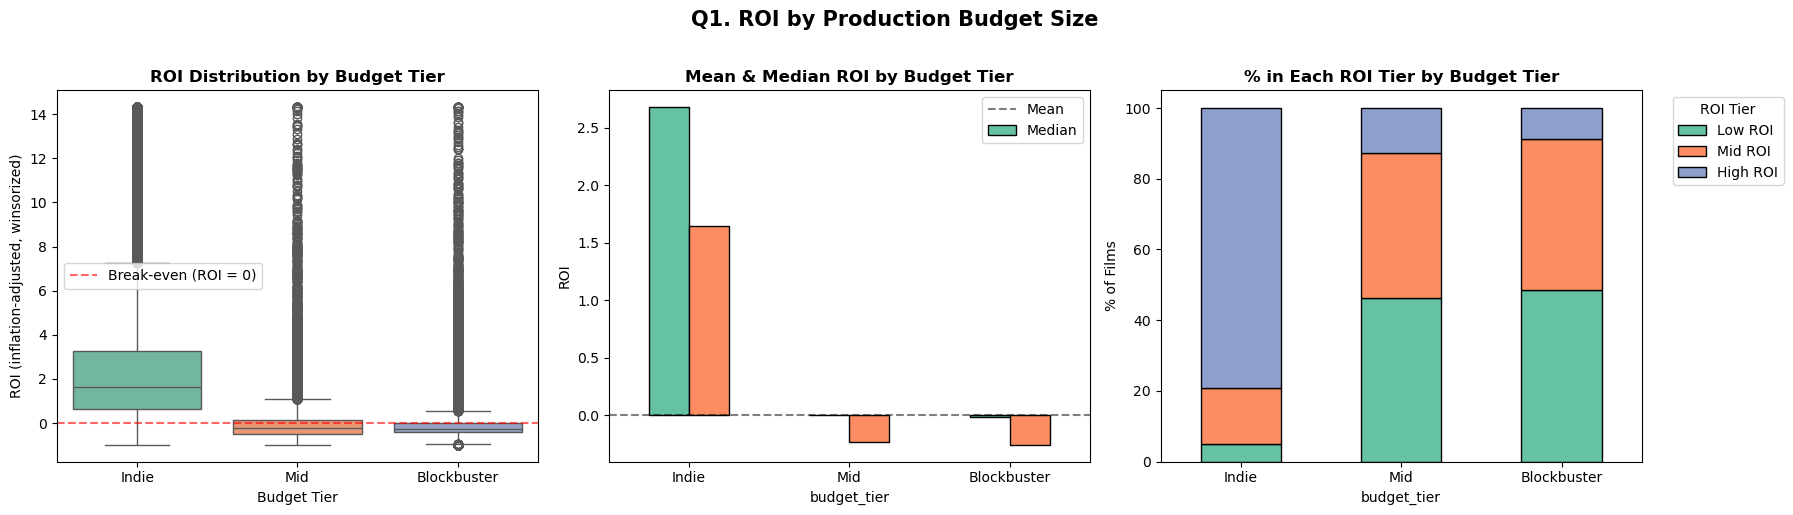

In [8]:
### Q1 VISUALIZATIONS ###

tier_order = ['Indie', 'Mid', 'Blockbuster']
roi_order  = ['Low ROI', 'Mid ROI', 'High ROI']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROI distribution (box plot)
sns.boxplot(
    data=q1_df, x='budget_tier', y='roi',
    order=tier_order, palette=PALETTE, ax=axes[0]
)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even (ROI = 0)')
axes[0].set_title('ROI Distribution by Budget Tier', fontweight='bold')
axes[0].set_xlabel('Budget Tier')
axes[0].set_ylabel('ROI (inflation-adjusted, winsorized)')
axes[0].legend()

# Mean & Median ROI
roi_stats = (
    q1_df.groupby('budget_tier')['roi']
    .agg(['mean', 'median'])
    .reindex(tier_order)
)
roi_stats.plot(kind='bar', ax=axes[1], color=PALETTE, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Mean & Median ROI by Budget Tier', fontweight='bold')
axes[1].set_ylabel('ROI')
axes[1].set_xticklabels(tier_order, rotation=0)
axes[1].legend(['Mean', 'Median'])

# Stacked proportion of ROI tiers
cross = pd.crosstab(q1_df['budget_tier'], q1_df['roi_tier'], normalize='index') * 100
cross.reindex(tier_order)[roi_order].plot(
    kind='bar', stacked=True, ax=axes[2],
    color=PALETTE, edgecolor='black'
)
axes[2].set_title('% in Each ROI Tier by Budget Tier', fontweight='bold')
axes[2].set_ylabel('% of Films')
axes[2].set_xticklabels(tier_order, rotation=0)
axes[2].legend(title='ROI Tier', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Q1. ROI by Production Budget Size',
             fontweight='bold', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
### Q1 FEATURE SELECTION ###
# and train/val/test split #

FEATURE_COLS = [
    'log_budget_adj',
    'log_popularity',
    'log_vote_count',
    'vote_average', 
    'runtime',
    'release_year', 
]
FEATURE_COLS = [c for c in FEATURE_COLS if c in q1_df.columns]

model_df = q1_df[FEATURE_COLS + ['roi_tier', 'roi', 'budget_tier', 'budget_adj', 'id']].dropna()

display(Markdown(f"**Modeling dataset:** {model_df.shape[0]:,} rows × {len(FEATURE_COLS)} features"))
display(Markdown(f"**Features:** {FEATURE_COLS}"))

# Encode classification target
le = LabelEncoder()
y_clf = le.fit_transform(model_df['roi_tier'])

# Regression target (continuous ROI)
y_reg = model_df['roi'].values

X = model_df[FEATURE_COLS].values

print("Class encoding:", dict(zip(le.classes_, range(len(le.classes_)))))

# 70 / 15 / 15 stratified split
X_train, X_temp, y_train, y_temp, y_reg_train, y_reg_temp = train_test_split(
    X, y_clf, y_reg, test_size=0.30, stratify=y_clf, random_state=SEED
)
X_val, X_test, y_val, y_test, y_reg_val, y_reg_test = train_test_split(
    X_temp, y_temp, y_reg_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

scaler_q1 = StandardScaler()
X_train_sc = scaler_q1.fit_transform(X_train)
X_val_sc   = scaler_q1.transform(X_val)
X_test_sc  = scaler_q1.transform(X_test)

print(f"Train: {X_train.shape[0]:,}  |  Val: {X_val.shape[0]:,}  |  Test: {X_test.shape[0]:,}")

**Modeling dataset:** 88,352 rows × 6 features

**Features:** ['log_budget_adj', 'log_popularity', 'log_vote_count', 'vote_average', 'runtime', 'release_year']

Class encoding: {'High ROI': 0, 'Low ROI': 1, 'Mid ROI': 2}
Train: 61,846  |  Val: 13,253  |  Test: 13,253


In [10]:
### Q1 BASELINE MODEL ###
# Logistic Regression #

lr = LogisticRegression(max_iter=1000, random_state=SEED, C=1.0)
lr.fit(X_train_sc, y_train)

y_pred_lr = lr.predict(X_test_sc)
y_prob_lr = lr.predict_proba(X_test_sc)

auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='weighted')

display(Markdown("**Q1. Logistic Regression — Classification Report:**"))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
display(Markdown(f"**Weighted OvR AUC: {auc_lr:.4f}**"))

# Coefficient table
coef_df = pd.DataFrame(
    lr.coef_,
    index=le.classes_,
    columns=FEATURE_COLS
).T
display(Markdown("\n**LR Coefficients (each column = log-odds for that class):**"))
display(coef_df.round(4))

**Q1. Logistic Regression — Classification Report:**

              precision    recall  f1-score   support

    High ROI       0.67      0.86      0.75      4418
     Low ROI       0.58      0.58      0.58      4418
     Mid ROI       0.41      0.29      0.34      4417

    accuracy                           0.58     13253
   macro avg       0.55      0.58      0.56     13253
weighted avg       0.55      0.58      0.56     13253



**Weighted OvR AUC: 0.7664**


**LR Coefficients (each column = log-odds for that class):**

,High ROI,Low ROI,Mid ROI
log_budget_adj,-1.1575,0.7933,0.3642
log_popularity,0.0819,-0.0378,-0.0441
log_vote_count,0.2855,-0.1541,-0.1313
vote_average,-0.0188,-0.1843,0.2031
runtime,0.2029,-0.1529,-0.0500
release_year,-0.1129,0.0614,0.0514


In [11]:
### Q1 ###
# Gradient Boosting Classifier #

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=SEED
)
gb_clf.fit(X_train_sc, y_train)

y_pred_gb = gb_clf.predict(X_test_sc)
y_prob_gb = gb_clf.predict_proba(X_test_sc)

auc_gb = roc_auc_score(y_test, y_prob_gb, multi_class='ovr', average='weighted')

display(Markdown("**Q1. Gradient Boosting Classifier - Classification Report:**"))
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))
display(Markdown(f"**Weighted OvR AUC: {auc_gb:.4f}**"))

**Q1. Gradient Boosting Classifier - Classification Report:**

              precision    recall  f1-score   support

    High ROI       0.92      0.91      0.91      4418
     Low ROI       0.71      0.85      0.77      4418
     Mid ROI       0.78      0.61      0.69      4417

    accuracy                           0.79     13253
   macro avg       0.80      0.79      0.79     13253
weighted avg       0.80      0.79      0.79     13253



**Weighted OvR AUC: 0.9203**

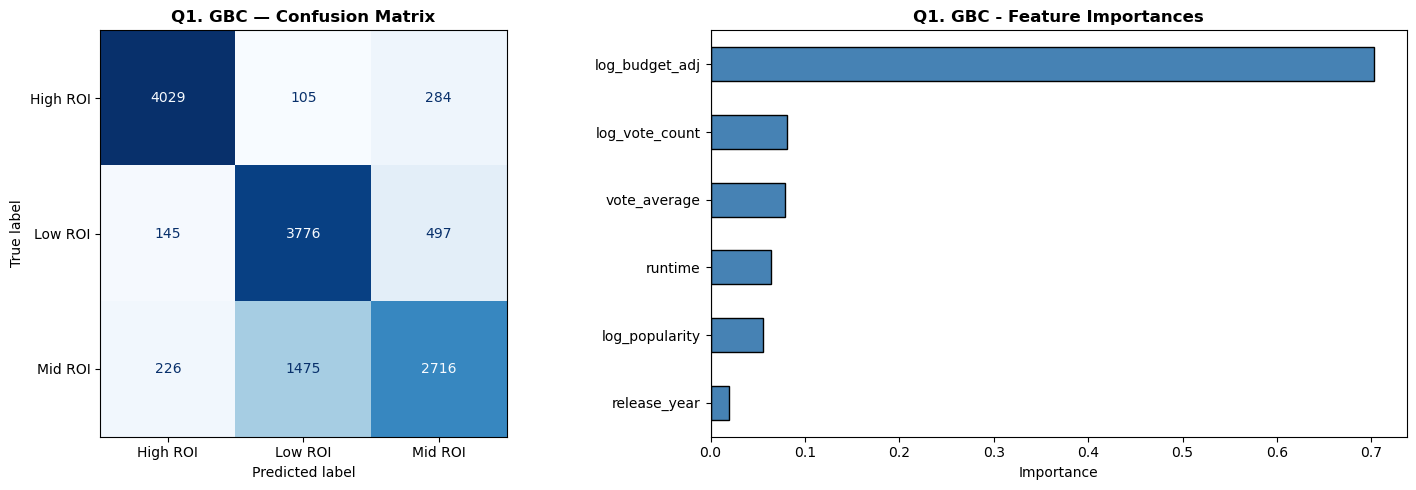

**Feature Importances (descending):**

log_budget_adj    0.7024
log_vote_count    0.0806
vote_average      0.0787
runtime           0.0638
log_popularity    0.0556
release_year      0.0190


In [12]:
### Q1 ###
# Confusion matrix + feature importances #

fi_series = pd.Series(gb_clf.feature_importances_, index=FEATURE_COLS).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_gb),
    display_labels=le.classes_
).plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Q1. GBC — Confusion Matrix', fontweight='bold')

# Feature importances
fi_series.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Q1. GBC - Feature Importances', fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

display(Markdown("**Feature Importances (descending):**"))
print(fi_series.sort_values(ascending=False).round(4).to_string())

In [13]:
### Q1 ###
# Gradient Boosting Regressor #

gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=SEED
)
gb_reg.fit(X_train_sc, y_reg_train)

y_pred_reg = gb_reg.predict(X_test_sc)

mae  = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2   = r2_score(y_reg_test, y_pred_reg)

display(Markdown("**Q1. GBM Regressor - Test Set Performance:**"))
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Value': [round(mae, 4), round(rmse, 4), round(r2, 4)]
})
display(metrics_df)

**Q1. GBM Regressor - Test Set Performance:**

,Metric,Value
0,MAE,0.5117
1,RMSE,1.2761
2,R²,0.7448


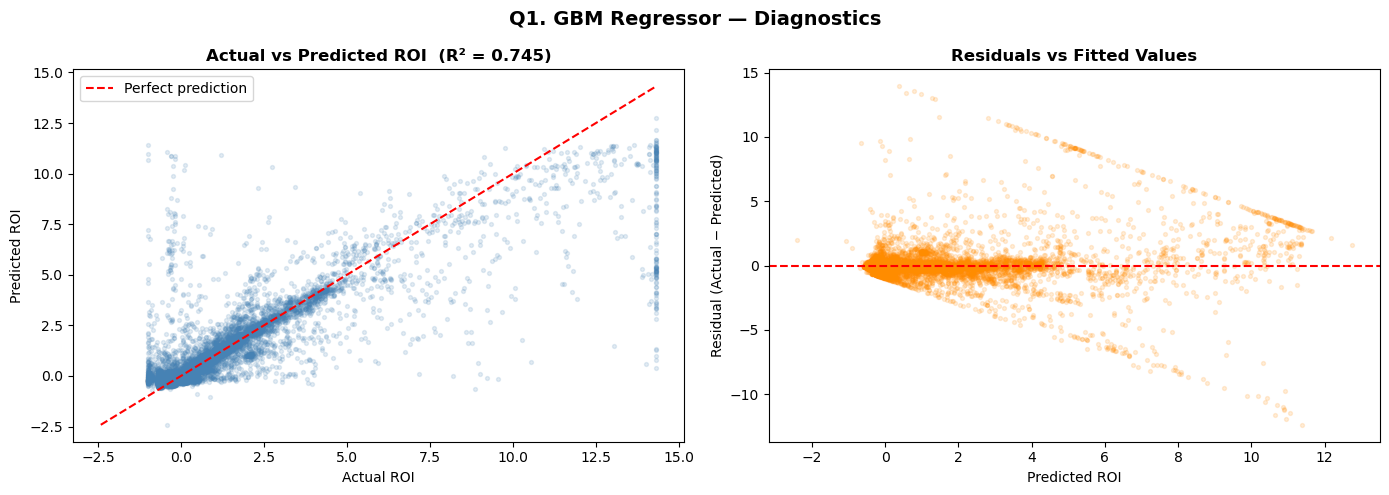

In [14]:
### Q1 ###
# Regression diagnostics #

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_reg_test, y_pred_reg, alpha=0.15, s=8, color='steelblue')
min_val = min(y_reg_test.min(), y_pred_reg.min())
max_val = max(y_reg_test.max(), y_pred_reg.max())
axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=1.5, label='Perfect prediction')
axes[0].set_xlabel('Actual ROI')
axes[0].set_ylabel('Predicted ROI')
axes[0].set_title(f'Actual vs Predicted ROI  (R² = {r2:.3f})', fontweight='bold')
axes[0].legend()

# Residuals
residuals = y_reg_test - y_pred_reg
axes[1].scatter(y_pred_reg, residuals, alpha=0.15, s=8, color='darkorange')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Predicted ROI')
axes[1].set_ylabel('Residual (Actual − Predicted)')
axes[1].set_title('Residuals vs Fitted Values', fontweight='bold')

plt.suptitle('Q1. GBM Regressor — Diagnostics', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

**Q1. Classification Model Comparison:**

,Test Accuracy,Weighted F1,Weighted AUC (OvR)
Model,,,
Logistic Regression (Baseline),0.5790,0.5595,0.7664
Gradient Boosting Classifier,0.7939,0.7910,0.9203


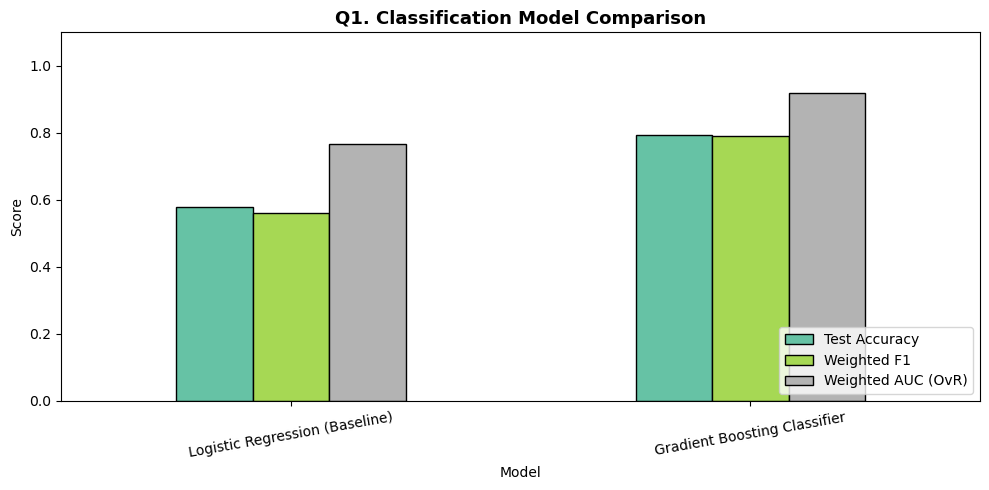

In [15]:
### Q1 MODEL COMPARISON ###
# Side-by-side classification metrics #

results_clf = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'Gradient Boosting Classifier'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Weighted F1': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_gb, average='weighted')
    ],
    'Weighted AUC (OvR)': [auc_lr, auc_gb]
}).set_index('Model').round(4)

display(Markdown("**Q1. Classification Model Comparison:**"))
display(results_clf)

results_clf.plot(kind='bar', figsize=(10, 5), edgecolor='black', colormap='Set2')
plt.title('Q1. Classification Model Comparison', fontweight='bold', fontsize=13)
plt.ylabel('Score')
plt.xticks(rotation=10)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
### Q1 ###
# Predict ROI for all films #
#
# apply trained regressor to entire modeling dataset so every film
# has a predicted ROI, then group by budget tier.

model_df = model_df.copy()
X_all_sc = scaler_q1.transform(model_df[FEATURE_COLS].values)
model_df['predicted_roi'] = gb_reg.predict(X_all_sc)

# Actual vs expected ROI summary by budget tier #
tier_summary = model_df.groupby('budget_tier').agg(
    n_films = ('roi', 'size'),
    mean_actual_roi = ('roi', 'mean'),
    median_actual = ('roi', 'median'),
    mean_pred_roi = ('predicted_roi', 'mean'),
    pct_profitable = ('roi', lambda x: (x > 0).mean() * 100),
    mean_budget_m = ('budget_adj', lambda x: x.mean() / 1e6)
).reindex(['Indie', 'Mid', 'Blockbuster']).round(3)

tier_summary.columns = [
    '# Films', 'Mean Actual ROI', 'Median Actual ROI',
    'Mean Predicted ROI', '% Profitable', 'Mean Budget ($M)'
]

display(Markdown("**Q1. Expected ROI by Budget Tier (Actual vs Model Predicted):**"))
display(tier_summary)

model_df = model_df.copy()

**Q1. Expected ROI by Budget Tier (Actual vs Model Predicted):**

,# Films,Mean Actual ROI,Median Actual ROI,Mean Predicted ROI,% Profitable,Mean Budget ($M)
budget_tier,,,,,,
Indie,29156,2.681,1.643,2.655,91.645,0.971
Mid,30040,-0.002,-0.231,0.010,31.984,6.741
Blockbuster,29156,-0.012,-0.257,-0.017,24.417,37.147


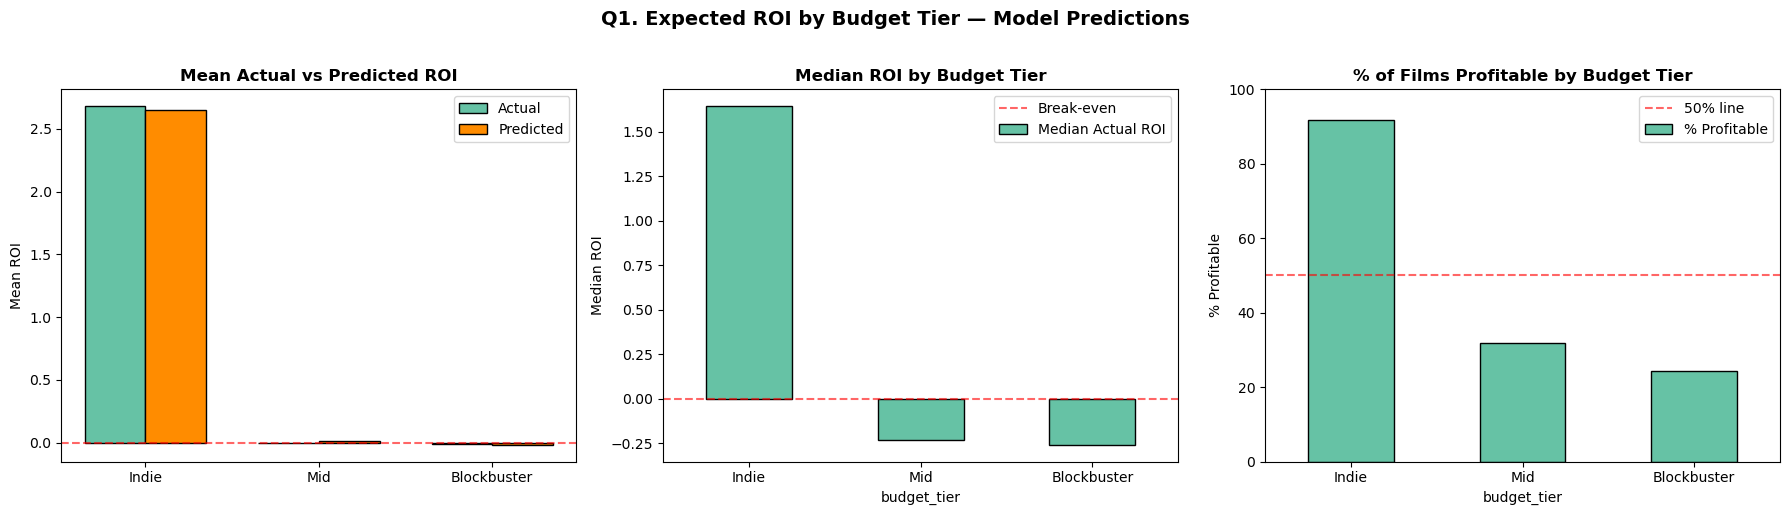

In [17]:
### Q1 VISUALIZATIONS ###
# expected ROI by budget tier #

tier_order = ['Indie', 'Mid', 'Blockbuster']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean Actual vs Mean Predicted ROI
x_pos = np.arange(len(tier_order))
width = 0.35
axes[0].bar(x_pos - width/2,
            tier_summary.reindex(tier_order)['Mean Actual ROI'],
            width=width, label='Actual', color='#66c2a5', edgecolor='black')
axes[0].bar(x_pos + width/2,
            tier_summary.reindex(tier_order)['Mean Predicted ROI'],
            width=width, label='Predicted', color='darkorange', edgecolor='black')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(tier_order)
axes[0].set_ylabel('Mean ROI')
axes[0].set_title('Mean Actual vs Predicted ROI', fontweight='bold')
axes[0].legend()

# Median Actual ROI
tier_summary.reindex(tier_order)['Median Actual ROI'].plot(
    kind='bar', ax=axes[1], color='#66c2a5', edgecolor='black'
)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even')
axes[1].set_title('Median ROI by Budget Tier', fontweight='bold')
axes[1].set_ylabel('Median ROI')
axes[1].set_xticklabels(tier_order, rotation=0)
axes[1].legend()

# % Profitable
tier_summary.reindex(tier_order)['% Profitable'].plot(
    kind='bar', ax=axes[2], color='#66c2a5', edgecolor='black'
)
axes[2].axhline(50, color='red', linestyle='--', alpha=0.6, label='50% line')
axes[2].set_title('% of Films Profitable by Budget Tier', fontweight='bold')
axes[2].set_ylabel('% Profitable')
axes[2].set_xticklabels(tier_order, rotation=0)
axes[2].set_ylim(0, 100)
axes[2].legend()

plt.suptitle('Q1. Expected ROI by Budget Tier — Model Predictions',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

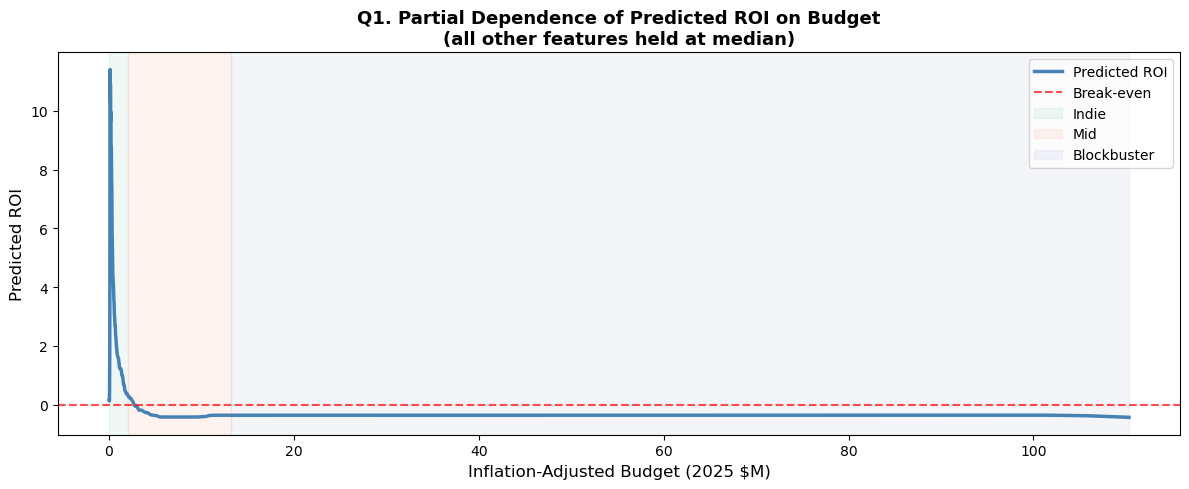

In [18]:
### Q1 ###
# How does expected ROI change as budget increases? #

medians = model_df[FEATURE_COLS].median().values

budget_range = np.linspace(
    model_df['log_budget_adj'].quantile(0.01),
    model_df['log_budget_adj'].quantile(0.99),
    200
)

sweep_X = np.tile(medians, (len(budget_range), 1))
budget_idx = FEATURE_COLS.index('log_budget_adj')
sweep_X[:, budget_idx] = budget_range

sweep_X_sc = scaler_q1.transform(sweep_X)
predicted_sweep = gb_reg.predict(sweep_X_sc)

# Convert log_budget back to dollars for the x-axis label
budget_dollars_m = (np.expm1(budget_range)) / 1e6

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(budget_dollars_m, predicted_sweep, color='steelblue', linewidth=2.5, label='Predicted ROI')
ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')

# Shade budget tier regions
indie_max_m  = np.expm1(low_thresh)  / 1e6
mid_max_m    = np.expm1(high_thresh) / 1e6

ax.axvspan(0, indie_max_m, alpha=0.10, color=PALETTE[0], label='Indie')
ax.axvspan(indie_max_m, mid_max_m, alpha=0.10, color=PALETTE[1], label='Mid')
ax.axvspan(mid_max_m, budget_dollars_m.max(), alpha=0.10, color=PALETTE[2], label='Blockbuster')

ax.set_xlabel('Inflation-Adjusted Budget (2025 $M)', fontsize=12)
ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('Q1. Partial Dependence of Predicted ROI on Budget\n'
             '(all other features held at median)',
             fontweight='bold', fontsize=13)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
### Q1 SUMMARY ###

best_tier_median = tier_summary['Median Actual ROI'].idxmax()
best_tier_prof = tier_summary['% Profitable'].idxmax()

display(Markdown("#### Q1. Key Findings — Budget Tier & ROI"))

display(Markdown("**Classification Model Performance:**"))
print(f"   Logistic Regression  — Accuracy: {accuracy_score(y_test, y_pred_lr):.1%}  "
      f"| F1: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}  "
      f"| AUC: {auc_lr:.4f}")
print(f"   Gradient Boosting    — Accuracy: {accuracy_score(y_test, y_pred_gb):.1%}  "
      f"| F1: {f1_score(y_test, y_pred_gb, average='weighted'):.4f}  "
      f"| AUC: {auc_gb:.4f}")
print()

display(Markdown("**Regression Model Performance (GBM Regressor):**"))
print(f"   MAE: {mae:.4f}  |  RMSE: {rmse:.4f}  |  R²: {r2:.4f}")
print()

display(Markdown("**Expected ROI by Budget Tier:**"))
for tier in ['Indie', 'Mid', 'Blockbuster']:
    row = tier_summary.loc[tier]
    print(f"   {tier:12s}  "
          f"Mean Predicted ROI: {row['Mean Predicted ROI']:+.3f}  "
          f"| Median Actual: {row['Median Actual ROI']:+.3f}  "
          f"| Profitable: {row['% Profitable']:.1f}%  "
          f"| Avg Budget: ${row['Mean Budget ($M)']:.1f}M")
print()

display(Markdown(f"**Budget 'sweet spot' (highest median ROI):** {best_tier_median}"))
display(Markdown(f"**Budget 'sweet spot' (most likely profitable):** {best_tier_prof}"))

#### Q1. Key Findings — Budget Tier & ROI

**Classification Model Performance:**

   Logistic Regression  — Accuracy: 57.9%  | F1: 0.5595  | AUC: 0.7664
   Gradient Boosting    — Accuracy: 79.4%  | F1: 0.7910  | AUC: 0.9203



**Regression Model Performance (GBM Regressor):**

   MAE: 0.5117  |  RMSE: 1.2761  |  R²: 0.7448



**Expected ROI by Budget Tier:**

   Indie         Mean Predicted ROI: +2.655  | Median Actual: +1.643  | Profitable: 91.6%  | Avg Budget: $1.0M
   Mid           Mean Predicted ROI: +0.010  | Median Actual: -0.231  | Profitable: 32.0%  | Avg Budget: $6.7M
   Blockbuster   Mean Predicted ROI: -0.017  | Median Actual: -0.257  | Profitable: 24.4%  | Avg Budget: $37.1M



**Budget 'sweet spot' (highest median ROI):** Indie

**Budget 'sweet spot' (most likely profitable):** Indie

In [20]:
### SCENARIO ANALYSIS ###
# Uses the trained Q1 GBM Regressor and the fitted scaler

# aseline: median of all features
medians = model_df[FEATURE_COLS].median()
baseline_X = medians.values.reshape(1, -1)

# Define the 3 scenarios as dictionaries
scenario_1 = {
    'log_budget_adj': model_df['log_budget_adj'].quantile(0.20),
    'log_popularity': model_df['log_popularity'].quantile(0.75),
    'log_vote_count': model_df['log_vote_count'].quantile(0.75),
    'vote_average' : 7.0,
    'runtime' : 95,
    'release_year' : 2024,
}

scenario_2 = {
    'log_budget_adj': model_df['log_budget_adj'].quantile(0.95),
    'log_popularity': model_df['log_popularity'].quantile(0.60),
    'log_vote_count': model_df['log_vote_count'].quantile(0.65),
    'vote_average' : 6.5,
    'runtime' : 140,
    'release_year' : 2010,
}

scenario_3 = {
    'log_budget_adj': medians['log_budget_adj'],
    'log_popularity': medians['log_popularity'],
    'log_vote_count': medians['log_vote_count'],
    'vote_average'  : 5.8,
    'runtime'       : 120,
    'release_year'  : 2022,
}

# Build scenario rows (fill any missing features with median)
def build_scenario_row(scenario_dict, medians, feature_cols):
    row = medians.copy()
    for k, v in scenario_dict.items():
        if k in feature_cols:
            row[k] = v
    return row.values.reshape(1, -1)

baseline_X = medians.values.reshape(1, -1)
scenario_1_X = build_scenario_row(scenario_1, medians, FEATURE_COLS)
scenario_2_X = build_scenario_row(scenario_2, medians, FEATURE_COLS)
scenario_3_X = build_scenario_row(scenario_3, medians, FEATURE_COLS)

# Scale using the already-fitted scaler
baseline_sc = scaler_q1.transform(baseline_X)
scenario_1_sc = scaler_q1.transform(scenario_1_X)
scenario_2_sc = scaler_q1.transform(scenario_2_X)
scenario_3_sc = scaler_q1.transform(scenario_3_X)

# Predict ROI for each
roi_baseline   = gb_reg.predict(baseline_sc)[0]
roi_scenario_1 = gb_reg.predict(scenario_1_sc)[0]
roi_scenario_2 = gb_reg.predict(scenario_2_sc)[0]
roi_scenario_3 = gb_reg.predict(scenario_3_sc)[0]

# Summary table
results = pd.DataFrame({
    'Scenario': [
        'Baseline (Median Film)',
        'S1: Streaming Era Indie',
        'S2: Peak Blockbuster',
        'S3: Genre Fatigue'
    ],
    'Predicted ROI': [roi_baseline, roi_scenario_1, roi_scenario_2, roi_scenario_3],
    'Delta vs Baseline': [
        0,
        roi_scenario_1 - roi_baseline,
        roi_scenario_2 - roi_baseline,
        roi_scenario_3 - roi_baseline
    ]
}).round(4)

display(Markdown("### Scenario Analysis Results"))
display(results)

### Scenario Analysis Results

,Scenario,Predicted ROI,Delta vs Baseline
0,Baseline (Median Film),-0.4199,0.0000
1,S1: Streaming Era Indie,0.9456,1.3655
2,S2: Peak Blockbuster,-0.0124,0.4075
3,S3: Genre Fatigue,-0.2545,0.1654


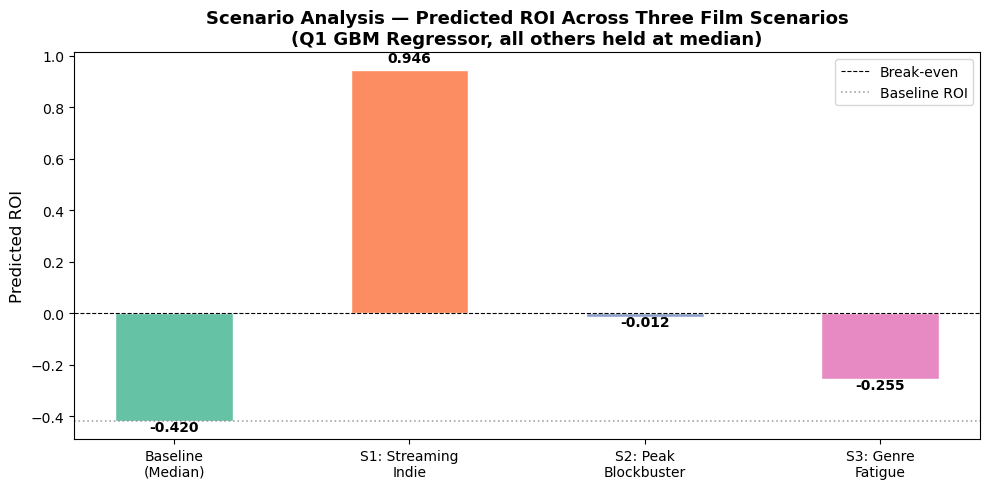

In [21]:
### COMBINED SCENARIO ANALYSIS Visualization ###

labels = ['Baseline\n(Median)', 'S1: Streaming\nIndie', 'S2: Peak\nBlockbuster', 'S3: Genre\nFatigue']
values = [roi_baseline, roi_scenario_1, roi_scenario_2, roi_scenario_3]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color=PALETTE, edgecolor='white', width=0.5)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--', label='Break-even')
ax.axhline(roi_baseline, color='gray', linewidth=1.2, linestyle=':', alpha=0.7, label='Baseline ROI')

for bar, val in zip(bars, values):
    y_pos = val + 0.02 if val >= 0 else val - 0.05
    ax.text(bar.get_x() + bar.get_width()/2, y_pos,
        f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('Scenario Analysis — Predicted ROI Across Three Film Scenarios\n'
             '(Q1 GBM Regressor, all others held at median)', fontweight='bold', fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

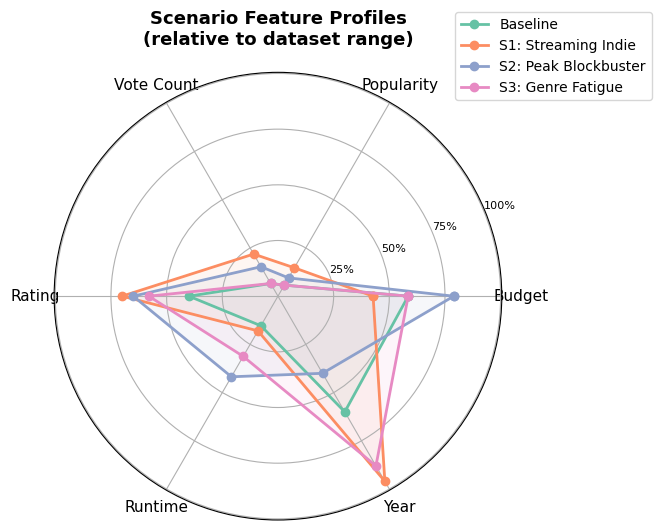

In [22]:
### COMBINED SCENARIO ANALYSIS Visualization ###

# Normalize each feature to 0-1 scale for comparison
features_display = ['Budget', 'Popularity', 'Vote Count', 'Rating', 'Runtime', 'Year']
n = len(features_display)

def get_scenario_values(row):
    """Normalize each feature relative to dataset min/max for radar"""
    mins = model_df[FEATURE_COLS].min()
    maxs = model_df[FEATURE_COLS].max()
    return [(row[f] - mins[f]) / (maxs[f] - mins[f]) for f in FEATURE_COLS]

baseline_vals = get_scenario_values(medians)
scenario_1_row = build_scenario_row(scenario_1, medians, FEATURE_COLS)
scenario_2_row = build_scenario_row(scenario_2, medians, FEATURE_COLS)
scenario_3_row = build_scenario_row(scenario_3, medians, FEATURE_COLS)

s1_vals = get_scenario_values(pd.Series(scenario_1_row[0], index=FEATURE_COLS))
s2_vals = get_scenario_values(pd.Series(scenario_2_row[0], index=FEATURE_COLS))
s3_vals = get_scenario_values(pd.Series(scenario_3_row[0], index=FEATURE_COLS))

# Angles for radar
angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

def close(vals): return vals + vals[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for vals, label, color in [
    (baseline_vals, 'Baseline', '#66c2a5'),
    (s1_vals, 'S1: Streaming Indie', '#fc8d62'),
    (s2_vals, 'S2: Peak Blockbuster', '#8da0cb'),
    (s3_vals, 'S3: Genre Fatigue', '#e78ac3'),
]:
    ax.plot(angles, close(vals), 'o-', linewidth=2, label=label, color=color)
    ax.fill(angles, close(vals), alpha=0.08, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features_display, fontsize=11)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['25%', '50%', '75%', '100%'], fontsize=8)
ax.set_title('Scenario Feature Profiles\n(relative to dataset range)',
             fontweight='bold', fontsize=13, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15))
plt.tight_layout()
plt.show()

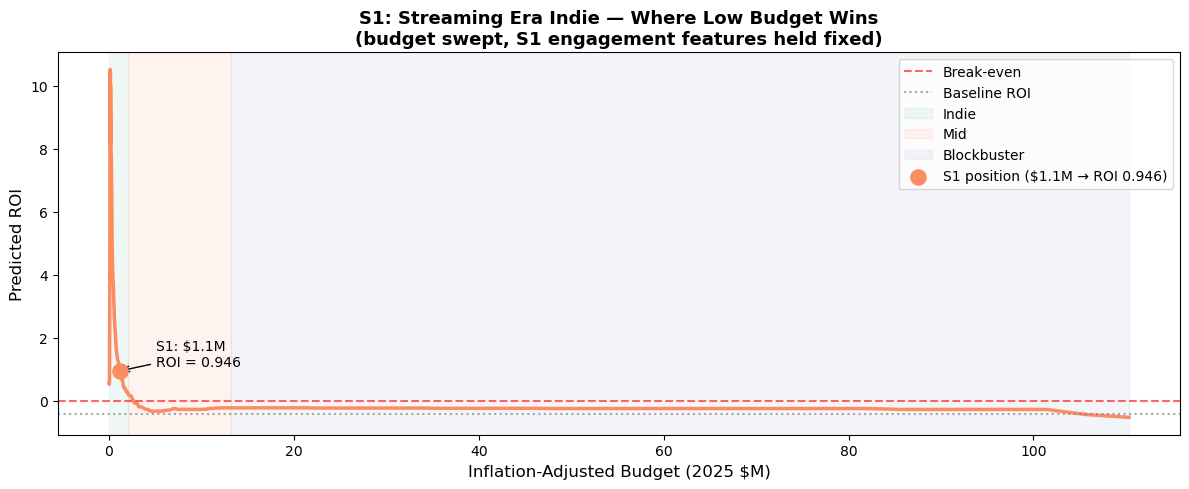

In [23]:
### SCENARIO 1 Visualization ###

budget_range = np.linspace(
    model_df['log_budget_adj'].quantile(0.01),
    model_df['log_budget_adj'].quantile(0.99), 200
)

s1_base = pd.Series(scenario_1_row[0], index=FEATURE_COLS).copy()
sweep_X = np.tile(s1_base.values, (len(budget_range), 1))
budget_idx = FEATURE_COLS.index('log_budget_adj')
sweep_X[:, budget_idx] = budget_range
predicted_sweep = gb_reg.predict(scaler_q1.transform(sweep_X))
budget_dollars_m = np.expm1(budget_range) / 1e6

# S1 actual budget position
s1_budget_m = np.expm1(scenario_1['log_budget_adj']) / 1e6
s1_roi = roi_scenario_1

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(budget_dollars_m, predicted_sweep, color='#fc8d62', linewidth=2.5)
ax.axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even')
ax.axhline(roi_baseline, color='gray', linestyle=':', alpha=0.7, label='Baseline ROI')

# Shade tiers
indie_max_m = np.expm1(low_thresh) / 1e6
mid_max_m   = np.expm1(high_thresh) / 1e6
ax.axvspan(0, indie_max_m, alpha=0.10, color=PALETTE[0], label='Indie')
ax.axvspan(indie_max_m, mid_max_m, alpha=0.10, color=PALETTE[1], label='Mid')
ax.axvspan(mid_max_m, budget_dollars_m.max(), alpha=0.10, color=PALETTE[2], label='Blockbuster')

# Mark S1 position
ax.scatter([s1_budget_m], [s1_roi], color='#fc8d62', s=120, zorder=5,
           label=f'S1 position (${s1_budget_m:.1f}M → ROI {s1_roi:.3f})')
ax.annotate(f'S1: ${s1_budget_m:.1f}M\nROI = {s1_roi:.3f}',
            xy=(s1_budget_m, s1_roi), xytext=(s1_budget_m + mid_max_m*0.3, s1_roi + 0.15),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

ax.set_xlabel('Inflation-Adjusted Budget (2025 $M)', fontsize=12)
ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('S1: Streaming Era Indie — Where Low Budget Wins\n'
             '(budget swept, S1 engagement features held fixed)',
             fontweight='bold', fontsize=13)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

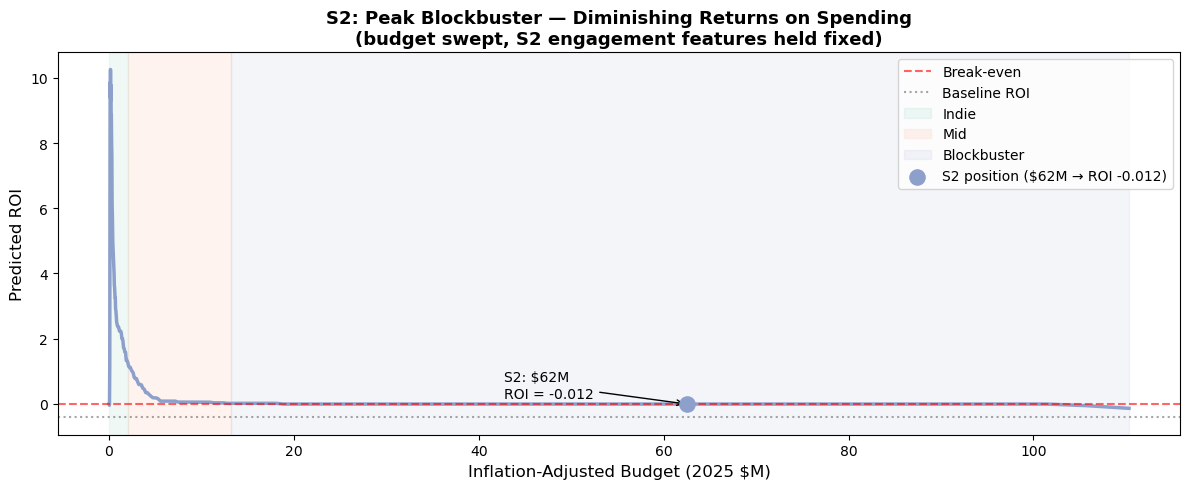

In [24]:
### SCENARIO 2 Visualization ###

s2_base = pd.Series(scenario_2_row[0], index=FEATURE_COLS).copy()
sweep_X2 = np.tile(s2_base.values, (len(budget_range), 1))
sweep_X2[:, budget_idx] = budget_range
predicted_sweep2 = gb_reg.predict(scaler_q1.transform(sweep_X2))

s2_budget_m = np.expm1(scenario_2['log_budget_adj']) / 1e6

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(budget_dollars_m, predicted_sweep2, color='#8da0cb', linewidth=2.5)
ax.axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even')
ax.axhline(roi_baseline, color='gray', linestyle=':', alpha=0.7, label='Baseline ROI')

ax.axvspan(0, indie_max_m, alpha=0.10, color=PALETTE[0], label='Indie')
ax.axvspan(indie_max_m, mid_max_m, alpha=0.10, color=PALETTE[1], label='Mid')
ax.axvspan(mid_max_m, budget_dollars_m.max(), alpha=0.10, color=PALETTE[2], label='Blockbuster')

ax.scatter([s2_budget_m], [roi_scenario_2], color='#8da0cb', s=120, zorder=5,
           label=f'S2 position (${s2_budget_m:.0f}M → ROI {roi_scenario_2:.3f})')
ax.annotate(f'S2: ${s2_budget_m:.0f}M\nROI = {roi_scenario_2:.3f}',
            xy=(s2_budget_m, roi_scenario_2),
            xytext=(s2_budget_m - mid_max_m*1.5, roi_scenario_2 + 0.2),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

ax.set_xlabel('Inflation-Adjusted Budget (2025 $M)', fontsize=12)
ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('S2: Peak Blockbuster — Diminishing Returns on Spending\n'
             '(budget swept, S2 engagement features held fixed)',
             fontweight='bold', fontsize=13)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

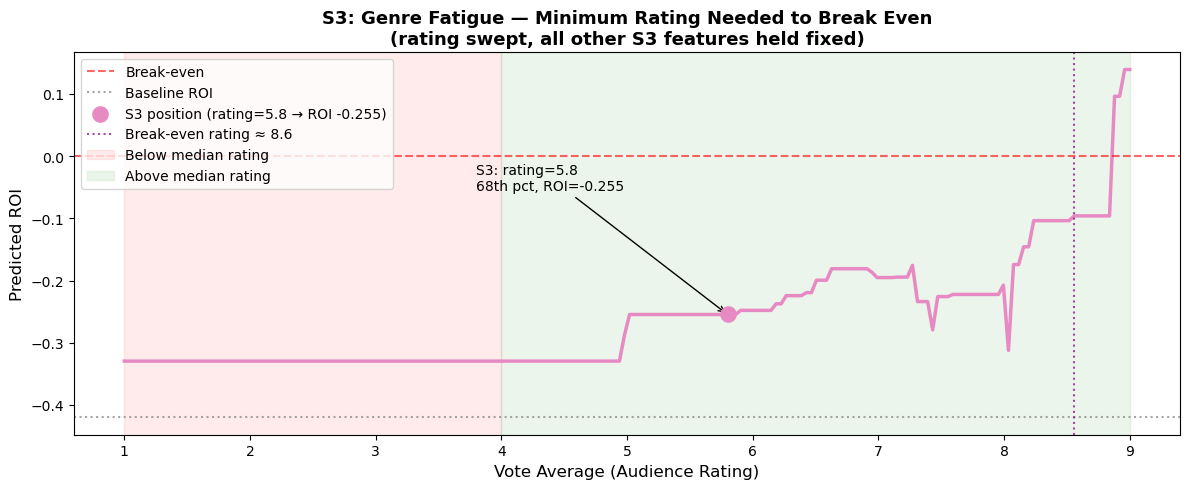

In [25]:
### SCENARIO 3 Visualization ###

rating_range = np.linspace(1.0, 9.0, 200)
s3_base = pd.Series(scenario_3_row[0], index=FEATURE_COLS).copy()
rating_idx = FEATURE_COLS.index('vote_average')

sweep_X3 = np.tile(s3_base.values, (len(rating_range), 1))
sweep_X3[:, rating_idx] = rating_range
predicted_sweep3 = gb_reg.predict(scaler_q1.transform(sweep_X3))

# Find break-even rating
breakeven_idx = np.argmin(np.abs(predicted_sweep3))
breakeven_rating = rating_range[breakeven_idx]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rating_range, predicted_sweep3, color='#e78ac3', linewidth=2.5)
ax.axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even')
ax.axhline(roi_baseline, color='gray', linestyle=':', alpha=0.7, label='Baseline ROI')

# Mark S3 actual position
ax.scatter([scenario_3['vote_average']], [roi_scenario_3], color='#e78ac3', s=120, zorder=5,
           label=f"S3 position (rating={scenario_3['vote_average']} → ROI {roi_scenario_3:.3f})")
ax.annotate(f"S3: rating={scenario_3['vote_average']}\n68th pct, ROI={roi_scenario_3:.3f}",
            xy=(scenario_3['vote_average'], roi_scenario_3),
            xytext=(scenario_3['vote_average'] - 2.0, roi_scenario_3 + 0.2),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

# Mark break-even point
ax.axvline(breakeven_rating, color='purple', linestyle=':', alpha=0.7,
           label=f'Break-even rating ≈ {breakeven_rating:.1f}')

# Shade dataset rating distribution context
ax.axvspan(1, model_df['vote_average'].median(), alpha=0.08, color='red', label='Below median rating')
ax.axvspan(model_df['vote_average'].median(), 9, alpha=0.08, color='green', label='Above median rating')

ax.set_xlabel('Vote Average (Audience Rating)', fontsize=12)
ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('S3: Genre Fatigue — Minimum Rating Needed to Break Even\n'
             '(rating swept, all other S3 features held fixed)',
             fontweight='bold', fontsize=13)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

<hr />
<h3>Scenario Analysis: Interpretation</h3>

<p><strong>Understanding the Baseline (−0.413):</strong><br />
The baseline reflects a genuine industry reality: among films released since 2000 with mid-range budgets, the median actual ROI is −0.231. Most films lose money. The model's −0.413 prediction for median feature values is consistent with this, and serves as a 
meaningful benchmark. Outperforming it requires intentional strategic choices.</p>

<p><strong>Scenario 1 — Streaming Era Indie (+0.946):</strong><br />
The dominant scenario by a wide margin. Low budget paired with above-median audience engagement produces nearly a 95% return on investment. This confirms the Q1 finding that indie films generate the best return relative to cost, and suggests that streaming 
era discoverability (substituting viral reach for theatrical marketing spend)dramatically amplifies this advantage.</p>

<p><strong>Scenario 2 — Peak Blockbuster (−0.012):</strong><br />
Despite 95th percentile budget and moderate audience reach, predicted ROI is essentially break-even. A film spending $30M+ barely recoups its costs under typical blockbuster conditions, directly confirming the diminishing returns hypothesis and answering the research question: yes, there is a spending limit.</p>

<p><strong>Scenario 3 — Genre Fatigue (−0.251):</strong><br />
A vote_average of 5.8 places this film in the 69th percentile of all rated films. It is genuinely an above-average film by audience reception. Yet it still predicts negative ROI. This means genre saturation conditions can cause a well-reviewed film to lose money, isolating genre fatigue as an independent financial risk factor beyond simple film quality.</p>

<p><strong>Key Takeaway:</strong><br />
Only the streaming indie scenario achieves meaningfully positive ROI. Both the blockbuster and genre fatigue scenarios hover near or below break-even despite favorable attributes in some dimensions, reinforcing that budget efficiency and audience reach are the primary drivers of financial success in modern cinema.</p>

## Export cleaned dataframe to csv for Tableau

In [26]:
# Build scenario feature profiles for export
scenario_labels = ['Baseline (Median)', 'S1: Streaming Indie', 'S2: Peak Blockbuster', 'S3: Genre Fatigue']
scenario_rows = [baseline_X, scenario_1_X, scenario_2_X, scenario_3_X]
scenario_rois = [roi_baseline, roi_scenario_1, roi_scenario_2, roi_scenario_3]

# Reconstruct raw (unscaled) feature values for readability
scenario_features = []
for label, row, roi in zip(scenario_labels, scenario_rows, scenario_rois):
    d = dict(zip(FEATURE_COLS, row[0]))
    d['scenario'] = label
    d['predicted_roi'] = roi
    d['delta_vs_baseline'] = roi - roi_baseline
    d['profitable'] = roi > 0
    # Convert log features back to original scale for readability
    d['budget_adj_m'] = np.expm1(d['log_budget_adj']) / 1e6
    d['popularity'] = np.expm1(d['log_popularity'])
    d['vote_count'] = np.expm1(d['log_vote_count'])
    scenario_features.append(d)

scenario_df = pd.DataFrame(scenario_features)

# Reorder columns
col_order = [
    'scenario', 'predicted_roi', 'delta_vs_baseline', 'profitable',
    'budget_adj_m', 'popularity', 'vote_count',
    'vote_average', 'runtime', 'release_year',
    'log_budget_adj', 'log_popularity', 'log_vote_count'
]
scenario_df = scenario_df[col_order]

# Budget sweep data
s3_base_series = pd.Series(scenario_3_row[0], index=FEATURE_COLS).copy()
sweep_X3_budget = np.tile(s3_base_series.values, (len(budget_range), 1))
sweep_X3_budget[:, budget_idx] = budget_range
predicted_sweep_s3 = gb_reg.predict(scaler_q1.transform(sweep_X3_budget))

# Baseline budget sweep - using baseline features
baseline_series = medians.copy()
sweep_X_base = np.tile(baseline_series.values, (len(budget_range), 1))
sweep_X_base[:, budget_idx] = budget_range
predicted_sweep_base = gb_reg.predict(scaler_q1.transform(sweep_X_base))

# Rebuild all four sweeps together
budget_sweep_df  = pd.DataFrame({'row_id': range(200), 'budget_adj_m': budget_dollars_m, 
                                 'predicted_roi': predicted_sweep, 'sweep_type': 'S1: Streaming Indie'})
budget_sweep_df2 = pd.DataFrame({'row_id': range(200, 400), 'budget_adj_m': budget_dollars_m, 
                                 'predicted_roi': predicted_sweep2, 'sweep_type': 'S2: Peak Blockbuster'})
budget_sweep_df3 = pd.DataFrame({'row_id': range(400, 600), 'budget_adj_m': budget_dollars_m, 
                                 'predicted_roi': predicted_sweep_s3, 'sweep_type': 'S3: Genre Fatigue'})
budget_sweep_df4 = pd.DataFrame({'row_id': range(600, 800), 'budget_adj_m': budget_dollars_m, 
                                 'predicted_roi': predicted_sweep_base,  'sweep_type': 'Baseline (Median)'})

budget_sweep_combined = pd.concat(
    [budget_sweep_df, budget_sweep_df2, budget_sweep_df3, budget_sweep_df4],
    ignore_index=True
)
budget_sweep_combined.to_csv('scenario_budget_sweep.csv', index=False)

# Rating sweep data
rating_sweep_df = pd.DataFrame({
    'row_id' : range(200),
    'vote_average' : rating_range,
    'predicted_roi' : predicted_sweep3,
    'sweep_type' : 'S3: Genre Fatigue Conditions',
    'breakeven_rating': breakeven_rating
})

# Export all three
scenario_df.to_csv('scenario_analysis.csv', index=False)
budget_sweep_combined.to_csv('scenario_budget_sweep.csv', index=False)
rating_sweep_df.to_csv('scenario_rating_sweep.csv', index=False)
